This notebook assigns a land type (protected, embankment, char, etc.) to each mauza and then matches it against the responses in survey data. We also identify mauzas that are covered by multiple land types. We assign mauzas based on the land type that covers the majority of the mauza. 

In [1]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
data_dir = os.environ['AA_DATA_DIR']
in_fname = os.path.join(data_dir, 'exploration', 'bangladesh', 'CDP_Survey', 'household_locations_impactevaluation_matched.csv')
out_fname = os.path.join(data_dir, 'exploration', 'bangladesh', 'CDP_Survey', 'household_locations_impactevaluation_landtype.csv')

df_srv = pd.read_csv(in_fname)
gdf_mauz = gpd.read_file(os.path.join(data_dir, 'exploration', 'bangladesh', 'ADM_Shp', 'selected_distict_mauza.shp')).to_crs('EPSG:32646')
gdf_land = gpd.read_file(os.path.join(data_dir, 'exploration', 'bangladesh', 'Embankment', 'BGD_Landtypes_Eroded.shp')).to_crs('EPSG:32646')

To simplify the processing we'll dissolve the shapefile of land types so that each land type is a single multi-polygon.

In [3]:
gdf_land = gdf_land.dissolve(by='Exposure').reset_index()
print(len(gdf_land.index)==5) # Check that the number of elements in the gdf matches the number of land types

True


Let's also only get the subset of mauzas that are included in the survey data.

In [4]:
mauz_srv = df_srv.shp_id.unique()
gdf_mauz_srv = gdf_mauz[gdf_mauz['OBJECTID'].isin(mauz_srv)]
print(len(gdf_mauz_srv.index) == len(mauz_srv)) # Check that we have the same number of mauzas

True


For each mauza with survey data, we'll overlay against the land type layer to get the area of the mauza covered by each land type. For mauzas covered by multiple land types, we'll keep only the type with the greatest area.

In [5]:
gdf_merged = gpd.overlay(gdf_mauz_srv, gdf_land, how='intersection')
gdf_merged['area'] = gdf_merged.geometry.area

# Get the number of land types for each mauza
df_types = gdf_merged.groupby('OBJECTID').count()['AREA_1'].reset_index().rename(columns={'AREA_1': 'num_types'})

# Get the dominant type for each mauza
gdf_merged = gdf_merged.sort_values('area').drop_duplicates('OBJECTID', keep='last')

# Merges to get the right geometry and columns of interst
gdf_output = gdf_merged.merge(df_types, on='OBJECTID') # Get the types
gdf_output = gdf_mauz_srv.merge(gdf_output[['OBJECTID', 'Exposure', 'num_types']], on='OBJECTID') # Get the right geometry
df_output = df_srv.merge(gdf_output[['OBJECTID', 'Exposure', 'num_types']], left_on='shp_id', right_on='OBJECTID', how='left') # Get each of the survey responses


# Check that we still have the right number of mauzas
print(len(gdf_output) == len(mauz_srv))
print(len(df_output) == len(df_srv))

df_output.to_csv(out_fname)

True
True


<AxesSubplot:>

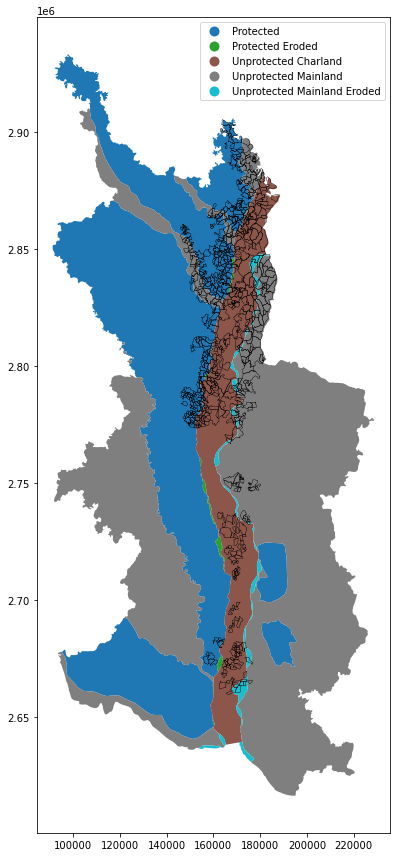

In [6]:
# What is the original land type?
fig, ax = plt.subplots(1, figsize=(10,15))
gdf_land.plot(column='Exposure', legend=True, ax=ax)
gdf_mauz_srv.boundary.plot(ax=ax, edgecolor="black", linewidth=0.4)

<AxesSubplot:>

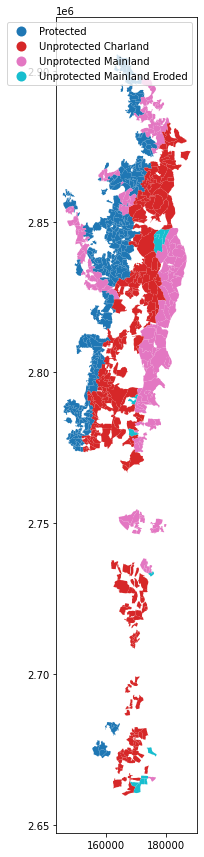

In [7]:
# What is the dominant land type for each mauza?
fig, ax = plt.subplots(1, figsize=(10,15))
gdf_output.plot(column='Exposure', legend=True, ax=ax)

<AxesSubplot:>

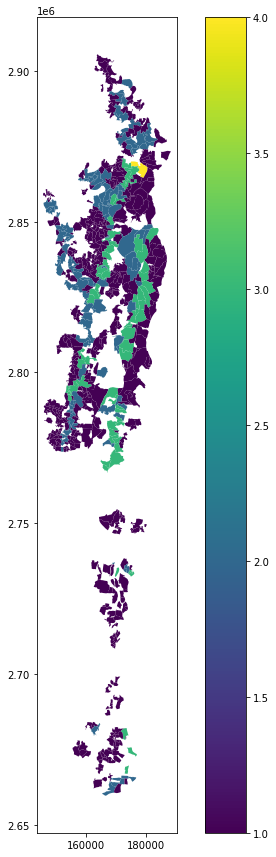

In [8]:
# Where are there mauzas with multiple land types?
fig, ax = plt.subplots(1, figsize=(10,15))
gdf_output.plot(column='num_types', legend=True, ax=ax)